In [ ]:
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
import numpy as np
import tensorflow as tf
from keras._tf_keras import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gensim
from google.colab import drive

drive.mount('/content/drive')

print(tf.__version__)

# functions
def plot_graphs(history, metric, save=False):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  if save:
    plt.savefig(f"{metric}.png")

Mounted at /content/drive
2.16.1


In [ ]:
raw_data = pd.read_csv(
    "./drive/MyDrive/ai-guild/clickbait_data.csv",
    names=["headline", "clickbait"]
)
# drop first line
raw_data = raw_data.iloc[1:]

raw_data_features = raw_data.copy()
raw_data_labels = raw_data_features.pop("clickbait").astype(int)
raw_data_features = np.array(raw_data_features)

TEST_SPLIT = 0.2
SEED = 29

train_features, test_features, train_labels, test_labels = train_test_split(
    raw_data_features,
    raw_data_labels,
    test_size=TEST_SPLIT,
    random_state=SEED
)

train_ds = tf.data.Dataset.from_tensor_slices((train_features, np.expand_dims(train_labels, -1)))
test_ds = tf.data.Dataset.from_tensor_slices((test_features, np.expand_dims(test_labels, -1)))

In [ ]:
# load word2vec model
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(
    "./drive/MyDrive/ai-guild/GoogleNews-vectors-negative300.bin",
    binary=True
)

In [ ]:
# create tokenizer
max_tokens = 10000
vectorize_layer = keras.layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=64)
vectorize_layer.adapt(train_features.flatten())

In [ ]:
vocab_size = len(vectorize_layer.get_vocabulary())
embedding_dim = 300 # word2vec embedding dim
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# filling embedding matrix
for index, word in enumerate(vectorize_layer.get_vocabulary()):
    if word in word_vectors.key_to_index:
        embedding_matrix[index] = word_vectors[word]

embedding_layer = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

In [46]:
model = keras.Sequential([
    vectorize_layer,
    embedding_layer,
    keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [48]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (1, 64)                     │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (1, 64, 300)                │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_14              │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [49]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch=int(len(train_features)/64),
    batch_size=64,
    validation_data=test_ds.repeat(),
    validation_steps=1024
)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.7158 - loss: 0.5020 - val_accuracy: 0.9131 - val_loss: 0.2209
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9081 - loss: 0.2457 - val_accuracy: 0.9150 - val_loss: 0.2203
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9522 - loss: 0.1425 - val_accuracy: 0.9268 - val_loss: 0.1847
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9458 - loss: 0.1592 - val_accuracy: 0.9346 - val_loss: 0.1703
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9264 - loss: 0.1728 - val_accuracy: 0.9443 - val_loss: 0.1667
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9311 - loss: 0.1792 - val_accuracy: 0.9385 - val_loss: 0.1539
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9299 - loss: 0.1766 - val_accuracy: 0.9395 - val_loss: 0.1624
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9285 - loss: 0.1562 

In [50]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (1, 64)                     │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (1, 64, 300)                │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (1, 60, 32)                 │          48,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (1, 56, 64)                 │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_14              │ (1, 64)                     │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 64)                     │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,187,685 (12.16 MB)

 Trainable params: 62,561 (244.38 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

 Optimizer params: 125,124 (488.77 KB)

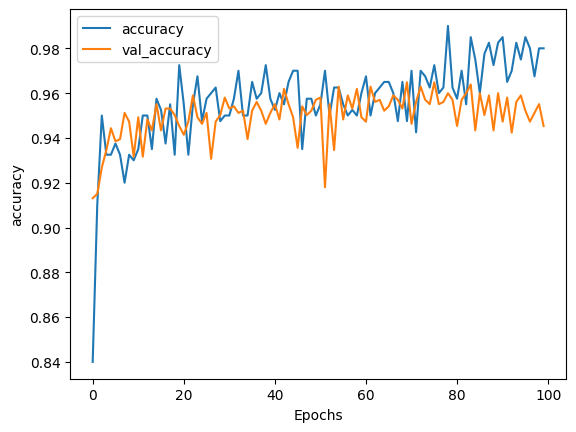

In [51]:
plot_graphs(history, 'accuracy', save=True)

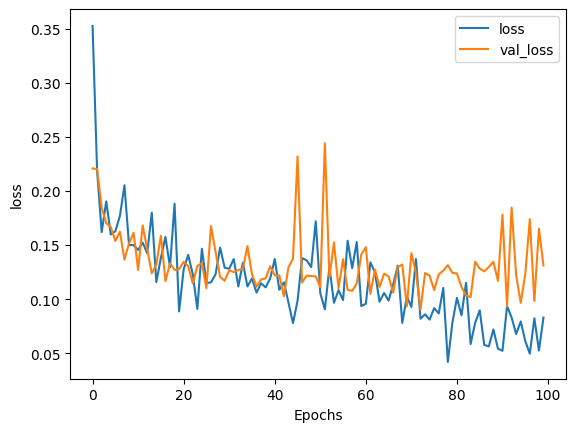

In [52]:
plot_graphs(history, 'loss', save=True)

In [53]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

6400/6400 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9545 - loss: 0.1223
Test Loss: 0.12620525062084198
Test Accuracy: 0.9515625238418579
